<a href="https://colab.research.google.com/github/cocobridge696/ML/blob/main/Obesity_Aclust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model as plot

In [ ]:
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00544/ObesityDataSet_raw_and_data_sinthetic%20(2).zip'
!unzip \*.zip

--2020-08-12 05:32:11--  https://archive.ics.uci.edu/ml/machine-learning-databases/00544/ObesityDataSet_raw_and_data_sinthetic%20(2).zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119205 (116K) [application/x-httpd-php]
Saving to: ‘ObesityDataSet_raw_and_data_sinthetic (2).zip’

ObesityDataSet_raw_ 100%[===================>] 116.41K  --.-KB/s    in 0.1s    

2020-08-12 05:32:11 (1.02 MB/s) - ‘ObesityDataSet_raw_and_data_sinthetic (2).zip’ saved [119205/119205]

Archive:  ObesityDataSet_raw_and_data_sinthetic (2).zip
  inflating: ObesityDataSet_raw_and_data_sinthetic.arff  
  inflating: ObesityDataSet_raw_and_data_sinthetic.csv  


In [ ]:
data=pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
data=data.reindex(np.random.permutation(data.index))
data.head()
#some numerical but alot of strings

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
1432,Female,22.538932,1.603963,82.012637,yes,yes,1.123672,1.014916,Sometimes,no,2.042078,no,1.846666,1.426103,no,Public_Transportation,Obesity_Type_I
1489,Female,41.318302,1.544937,77.053948,yes,yes,2.000000,3.000000,Sometimes,no,2.090413,no,0.000000,0.000000,Sometimes,Automobile,Obesity_Type_I
406,Male,33.000000,1.760000,66.500000,no,no,2.000000,3.000000,Sometimes,no,2.000000,no,3.000000,1.000000,Sometimes,Automobile,Normal_Weight
842,Male,19.226314,1.814255,85.255631,yes,yes,2.971351,3.390143,Sometimes,no,2.133767,no,2.318492,0.678618,Sometimes,Public_Transportation,Overweight_Level_I
289,Male,19.000000,1.880000,79.000000,no,no,2.000000,3.000000,Sometimes,no,3.000000,no,3.000000,0.000000,Sometimes,Automobile,Normal_Weight


In [ ]:
#identify possible strings
dictionary={}
string_cols=[]
for n in data.keys()[:-1]:
 if type(data[n][0])==str:
   string_cols.append(n)
   dictionary[n]=list(np.unique(data[n]))
print(dictionary)
print(string_cols)

{'Gender': ['Female', 'Male'], 'family_history_with_overweight': ['no', 'yes'], 'FAVC': ['no', 'yes'], 'CAEC': ['Always', 'Frequently', 'Sometimes', 'no'], 'SMOKE': ['no', 'yes'], 'SCC': ['no', 'yes'], 'CALC': ['Always', 'Frequently', 'Sometimes', 'no'], 'MTRANS': ['Automobile', 'Bike', 'Motorbike', 'Public_Transportation', 'Walking']}
['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


In [ ]:
vsplit=0.2
train,test=np.split(data,[int((1-vsplit)*len(data))])


trlabel=train['NObeyesdad']
telabel=test['NObeyesdad']


train=train.drop('NObeyesdad',1)
test=test.drop('NObeyesdad',1)

print(train.shape,test.shape)

(1688, 16) (423, 16)


In [ ]:
#covert labels to cluster ids for checking accuracy
labels=np.unique(trlabel)
i=0
for n in labels:
  trlabel[trlabel==n]=i
  i+=1

In [ ]:
print(labels)
print(trlabel)
print(np.unique(trlabel))

['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']
1432    2
1489    2
406     1
842     5
289     1
       ..
575     0
756     5
1387    2
326     1
513     0
Name: NObeyesdad, Length: 1688, dtype: object
[0 1 2 3 4 5 6]


In [ ]:
#create feature column
feature_col=[]

for n in string_cols:
  col=tf.feature_column.categorical_column_with_vocabulary_list(n,dictionary[n])
  feature_col.append(tf.feature_column.indicator_column(col))

num_cols=[x for x in data.keys()[:-1] if x not in string_cols ]
for n in num_cols:
  feature_col.append(tf.feature_column.numeric_column(n))


In [ ]:
print(train.head())

      Gender        Age    Height  ...       TUE       CALC                 MTRANS
1432  Female  22.538932  1.603963  ...  1.426103         no  Public_Transportation
1489  Female  41.318302  1.544937  ...  0.000000  Sometimes             Automobile
406     Male  33.000000  1.760000  ...  1.000000  Sometimes             Automobile
842     Male  19.226314  1.814255  ...  0.678618  Sometimes  Public_Transportation
289     Male  19.000000  1.880000  ...  0.000000  Sometimes             Automobile

[5 rows x 16 columns]


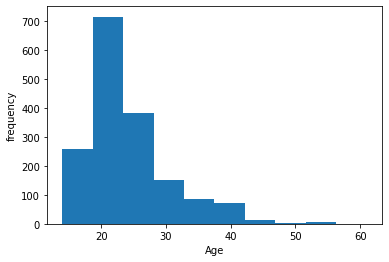

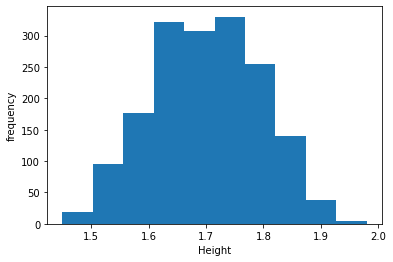

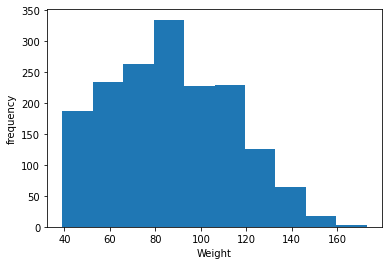

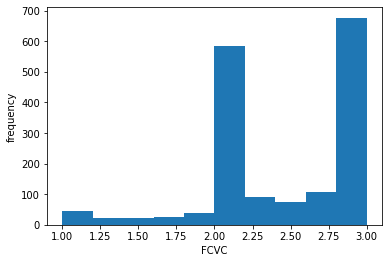

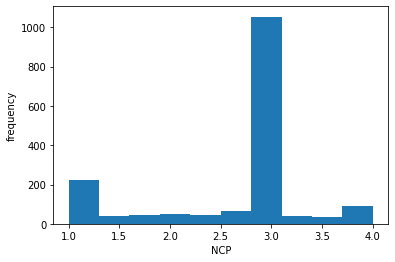

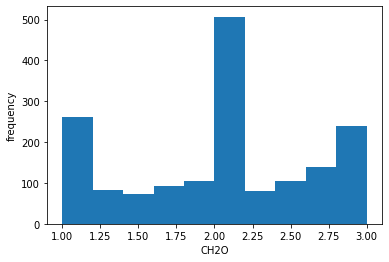

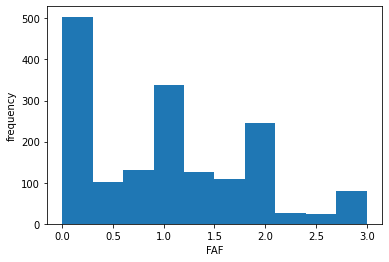

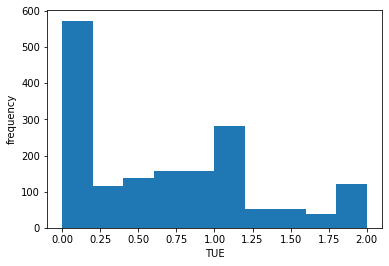

In [ ]:
#look at distribution
import matplotlib.pyplot as plt
for x in num_cols:
  plt.figure()
  plt.hist(list(train[x]))
  plt.xlabel(x)
  plt.ylabel('frequency')

In [ ]:
#Last 5 dont follow gaussian distrubution and thus need to be converted to quantiles
def quantize(data):
  col_quant=num_cols[-5:]
  num_Quant=20
 
  for n in col_quant:
    data[n]=pd.qcut(data[n],num_Quant,labels=False,duplicates='drop')
  #scale 0-1
    min=np.min(data[n])
    max=np.max(data[n])
    data[n]=(data[n]-min)/(max-min)
  return data

In [ ]:
#Normalize num cols
i=0
for data in [train,test]:
  for x in num_cols[:-5]:
    data[x]=(data[x]-data[x].mean())/data[x].std()
  if i==0:
    train=quantize(data)
    i=1
  else:
    test=quantize(data)

In [ ]:
print(train.head())

      Gender       Age    Height  ...       TUE       CALC                 MTRANS
1432  Female -0.271885 -1.038624  ...  0.833333         no  Public_Transportation
1489  Female  2.697826 -1.663962  ...  0.000000  Sometimes             Automobile
406     Male  1.382396  0.614476  ...  0.666667  Sometimes             Automobile
842     Male -0.795732  1.189269  ...  0.416667  Sometimes  Public_Transportation
289     Male -0.831521  1.885790  ...  0.000000  Sometimes             Automobile

[5 rows x 16 columns]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


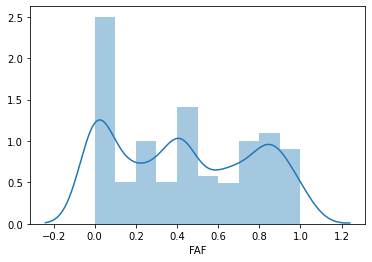

In [ ]:
#plot one 
import seaborn as sns
sns.distplot(train['FAF'])


In [ ]:
feat_lay=tf.keras.layers.DenseFeatures(feature_col)
#put in form of one hot vector
train=feat_lay(dict(train)).numpy()
test=feat_lay(dict(test)).numpy()

In [ ]:
print(train.shape)

(1688, 31)


In [ ]:
#Autoencode model
from tensorflow.keras.layers import Input,Dense

#generic autoencoder form

input=Input(shape=(train.shape[-1]))
encode1=Dense(250,activation='relu',kernel_initializer='glorot_uniform')(input)
encode2=Dense(250,activation='relu',kernel_initializer='glorot_uniform')(encode1)
encode3=Dense(1000,activation='relu',kernel_initializer='glorot_uniform')(encode2)
encode4=Dense(10,activation='relu',kernel_initializer='glorot_uniform')(encode3)
decode1=Dense(1000,activation='relu',kernel_initializer='glorot_uniform')(encode4)
decode2=Dense(250,activation='relu',kernel_initializer='glorot_uniform')(decode1)
decode3=Dense(250,activation='relu',kernel_initializer='glorot_uniform')(decode2)
output=Dense(31,activation='relu',kernel_initializer='glorot_uniform')(decode3)

auto_encoder=tf.keras.models.Model(inputs=input,outputs=output)
auto_encoder.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
auto_encoder.fit(x=train,y=train,epochs=100,batch_size=5,validation_data=(test,test))

Epoch 1/100
338/338 [==============================] - 2s 7ms/step - loss: 0.1572 - val_loss: 0.1251
Epoch 2/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1185 - val_loss: 0.1164
Epoch 3/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1129 - val_loss: 0.1107
Epoch 4/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1093 - val_loss: 0.1086
Epoch 5/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1075 - val_loss: 0.1077
Epoch 6/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1064 - val_loss: 0.1081
Epoch 7/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1048 - val_loss: 0.1041
Epoch 8/100
338/338 [==============================] - 2s 7ms/step - loss: 0.1036 - val_loss: 0.1086
Epoch 9/100
338/338 [==============================] - 2s 7ms/step - loss: 0.1032 - val_loss: 0.1050
Epoch 10/100
338/338 [==============================] - 2s 7ms/step - loss: 0.1022 - val_lo

In [ ]:
encoder=Model(inputs=input,outputs=encode4)


In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import InputSpec,Layer
class Cluster_lay(Layer):
  def __init__(self,No_clusters,weights=None,alpha=1.0,**kwargs):
    if 'input_shape' not in kwargs and 'input_dim' in kwargs:
      kwargs['input_shape']=(kwargs.pop('input_dim'),)
    super(Cluster_lay,self).__init__(**kwargs)
    self.No_clusters=No_clusters
    self.alpha=alpha
    self.initial_weights=weights
    self.input_spec=InputSpec(ndim=2)

  def build(self,input_shape):
    assert len(input_shape)==2
    input_dim=input_shape[1]
    self.input_spec=InputSpec(dtype=K.floatx(), shape=(None, input_dim))
    self.clusters = self.add_weight(shape=(self.No_clusters,input_dim), initializer='glorot_uniform', name='clusters')
    if self.initial_weights is not None:
      self.set_weights(self.initial_weights)
      del self.initial_weights
      self.built = True

  def call(self,inputs,**kwargs):
    #student t distribution to measure similarity between embedde point and centroid
    q=1.0/(1.0+(K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
    q**=(self.alpha+1.0)/2.0
    q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
    return q

  def compute_output_shape(self, input_shape):
    assert input_shape and len(input_shape) == 2
    return input_shape[0], self.n_clusters

  def get_config(self):
    config = {'n_clusters': self.No_clusters}
    base_config = super(ClusteringLayer, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

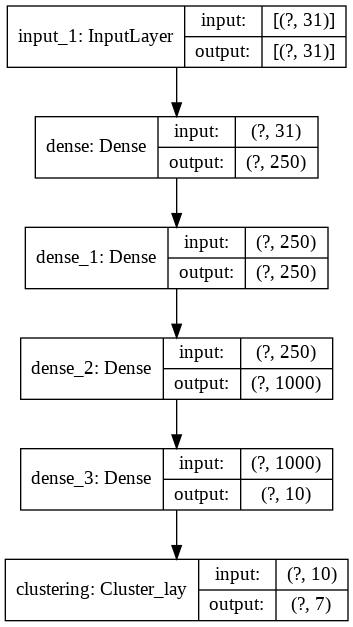

In [ ]:
No_clusters=7
cluster_layer=Cluster_lay(No_clusters,name='clustering')(encoder.output)
model=Model(inputs=encoder.input,outputs=cluster_layer)
plot(model,show_shapes=True)

In [ ]:
#set inital centroids
from sklearn.cluster import KMeans

kmean=KMeans(n_clusters=No_clusters,n_init=20)
centers=kmean.fit_predict(encoder.predict(train))
model.get_layer(name='clustering').set_weights([kmean.cluster_centers_])
model.compile(optimizer=tf.keras.optimizers.SGD(0.01,0.9),loss='kld')

In [ ]:
#auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [ ]:
from sklearn.metrics import accuracy_score as acc

maxiter = 8000
update_interval = 3
index=0
index_array=np.arange(train.shape[0])
batch_size=5
for ite in range(int(maxiter)):
  if ite % update_interval == 0:
    q = model.predict(train, verbose=0)# gives probabilty of each cluster
    p = target_distribution(q)  # update the auxiliary target distribution p

    # evaluate the clustering performance
    #predictions
    y_pred = q.argmax(1) #gives indicie of maximum probability on axis 1
    
    
  #train through batches
  idx = index_array[index * batch_size: min((index+1) * batch_size, train.shape[0])]
  loss = model.train_on_batch(x=train[idx], y=p[idx])
  index = index + 1 if (index + 1) * batch_size <= train.shape[0] else 0


# Munkres' Assingment algorith for accuracy

In [ ]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = np.array(trlabel).astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)   #7*7 matrix
# Creates confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1 #goes through all y_pred and adds one to the correct cell
ind = linear_assignment(-w)   #applys munkes algorith

M_acc=sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

cor_labl=w.argmax(1)
print('The accuracy is {}%'.format(np.round(M_acc*100,2)))
print('The changed cluster labels are {}'.format(cor_labl))

The accuracy is 33.29%
The changed cluster labels are [2 2 4 2 3 4 0]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


# Silhouette score

In [ ]:
from sklearn.metrics import silhouette_score
score=silhouette_score(train,y_pred,metric='euclidean')
print('The silhouette score is {}'.format(score))

The silhouette score is 0.1437501460313797


# Adjusted rand score

In [ ]:
from sklearn import metrics
rand=metrics.adjusted_rand_score(list(trlabel),y_pred)
print('The adjusted rand score is {}'.format(rand))

The adjusted rand score is 0.1534813869061538


# Most common ground truth label accuracy measure

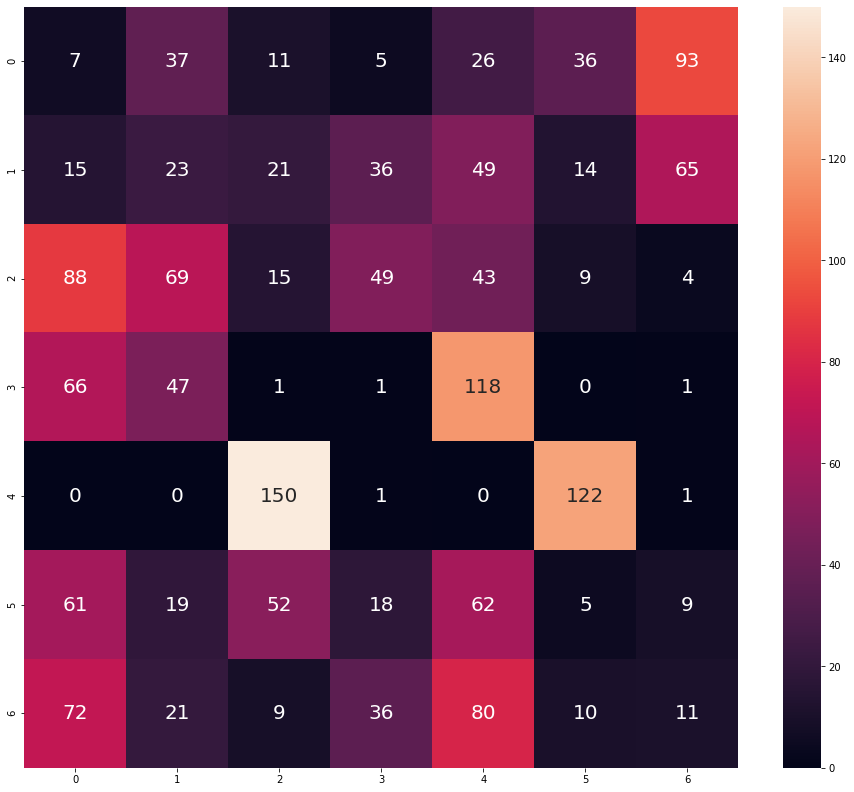

In [ ]:
#similar to munkes except final calc for acc
#highest number represents most common label in each cluster 
#use this most common truth label to relabel cluster
conf=metrics.confusion_matrix(list(trlabel), y_pred)
plt.figure(figsize=(16, 14))
sns.heatmap(conf, annot=True, fmt="d", annot_kws={"size": 20});

In [ ]:
num_labl=[0 for x in range(7)]
for n in range(7):
  list1=[]
  index=0
  list2=[]
  for x in y_pred:
    if x==n:
      list1.append(index)
    index+=1
  list2=(np.array(trlabel)[list1]).tolist()
  print(list2[:40])
  if list2 !=[]:
    num_labl[n]=max(list2,key=list2.count)

[2, 1, 2, 6, 2, 5, 2, 2, 5, 2, 3, 3, 6, 3, 2, 2, 6, 6, 5, 3, 2, 3, 2, 5, 2, 3, 3, 3, 1, 6, 3, 1, 5, 5, 0, 6, 2, 5, 1, 6]
[0, 6, 0, 0, 3, 5, 3, 0, 5, 2, 1, 6, 2, 0, 3, 0, 6, 2, 0, 2, 2, 2, 0, 0, 0, 6, 6, 2, 1, 6, 1, 0, 3, 3, 0, 3, 6, 3, 0, 2]
[4, 1, 4, 5, 4, 2, 4, 4, 4, 5, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 2, 5, 4, 2, 0, 4, 0, 4, 4, 4, 5, 4, 4, 4, 4, 1, 5, 5, 4, 4]
[2, 2, 2, 5, 1, 6, 2, 0, 2, 1, 6, 1, 2, 6, 2, 6, 2, 5, 2, 6, 5, 5, 2, 5, 0, 6, 5, 6, 1, 6, 6, 1, 1, 1, 0, 2, 5, 6, 6, 1]
[5, 1, 6, 2, 1, 0, 2, 3, 3, 1, 1, 3, 3, 3, 5, 3, 1, 3, 2, 3, 3, 1, 0, 0, 3, 5, 2, 2, 6, 5, 3, 2, 2, 1, 5, 2, 6, 2, 3, 1]
[4, 4, 4, 4, 0, 4, 4, 4, 0, 1, 1, 4, 4, 5, 0, 0, 1, 0, 4, 5, 4, 0, 1, 4, 0, 4, 4, 4, 4, 6, 4, 2, 4, 0, 4, 4, 0, 4, 4, 4]
[1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 5, 0, 1, 1, 0, 1, 1, 6, 0, 0, 1, 6, 0, 5, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0]


In [ ]:
print(num_labl)
#there are duplicates which shows low cluster accuracy

[2, 2, 4, 2, 3, 4, 0]


In [ ]:
#change cluster labels
for x in range(len(y_pred)):
  value=y_pred[x]
  y_pred[x]=num_labl[value]

In [ ]:
print(y_pred[:10])
print(list(trlabel)[:10])

[2 2 2 3 3 3 2 4 2 2]
[2, 2, 1, 5, 1, 6, 2, 4, 0, 2]


In [ ]:
from sklearn.metrics import accuracy_score as acc
accuracy=acc(list(trlabel),y_pred)
print('The accuracy is {}%'.format(int(accuracy*100)))

The accuracy is 40%


**Summary**

Best loss you can get using z score for all is around 0.28, although through examining distributions and applying approprite transformations (quantiles) the loss was reduced to 0.05. The cluster accuracy is around 47%. There is only a small amount of instances and this could be the reason for the low cluster accuracy. 